<a href="https://colab.research.google.com/github/akshaypat444/tensorflow_practice/blob/main/SkimLit_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os

## Get the data (PUBMED DATASET)

In [91]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [92]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [93]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [94]:
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess Data

In [95]:
def get_lines(filename):
  """
    Reads the file name and returns the
    lines of text as a list.
  """

  with open(filename, "r") as f:
    return f.readlines()

In [96]:
train_lines = get_lines(filenames[2])
train_lines[:20]

['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n',
 "RESULTS\tThe percentage of patients with abnormal LFTs decreased significantly from baseline to @-months ' follow-up .\n",
 'RE

In [97]:
def preprocess_text_with_line_numbers(filename):

  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"): # Start of the new abstract
      abstract_id = line
      abstract_lines = ""

    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      # Iterate through each line in a single abstract
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples

In [98]:
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')

In [99]:
%%time
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.5 µs


(180040, 30212, 30135)

In [100]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [101]:
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


In [102]:
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

In [103]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [104]:
# One hot encode labels

from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_label_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Encode Lables

In [105]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())

In [106]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [107]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Create Baseline Model

In [108]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB()),
])

model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [109]:
# Evaluate
model_0.score(X=val_sentences,
                y=val_labels_encoded)

0.7218323844829869

In [110]:
# Make predictions using out baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [111]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-06-04 02:47:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-04 02:47:19 (68.9 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [112]:
from helper_functions import calculate_results

In [113]:
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)

baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 1
* Preparing data for deep sequence model
1. Create vectorization layer
2. Create embedding layers

In [114]:
from tensorflow.keras import layers

In [115]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

In [116]:
import matplotlib.pyplot as plt

(array([1.6499e+04, 5.6664e+04, 5.2683e+04, 2.9050e+04, 1.3111e+04,
        5.6610e+03, 3.0490e+03, 1.5190e+03, 8.0800e+02, 4.3200e+02,
        2.2600e+02, 1.2800e+02, 7.7000e+01, 3.9000e+01, 3.0000e+01,
        1.5000e+01, 9.0000e+00, 8.0000e+00, 4.0000e+00, 8.0000e+00,
        7.0000e+00, 5.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1.        ,  10.83333333,  20.66666667,  30.5       ,
         40.33333333,  50.16666667,  60.        ,  69.83333333,
         79.66666667,  89.5       ,  99.33333333, 109.16666667,
        119.        , 128.83333333, 138.66666667, 148.5       ,
        158.33333333, 168.16666667, 178.        , 187.83333333,
        197.66666667, 207.5       , 217.33333333, 227.16666667,
        237.        , 246.83333333, 256.66666667, 266.5       ,
        276.33333333, 286.16666667, 296.        ]),
 <BarContainer object of 30 artists>)

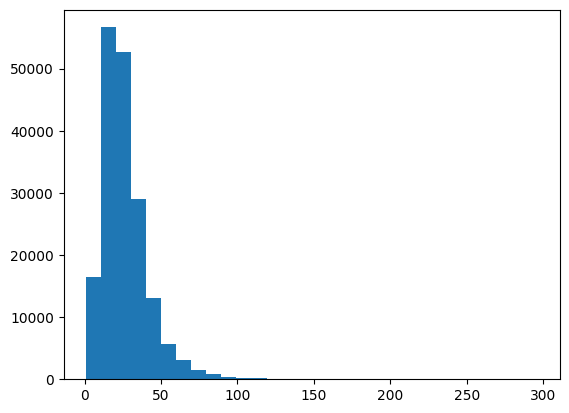

In [117]:
plt.hist(sent_lens, bins=30)

In [118]:
# How long of a sentence length covers 95% of example?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [119]:
# 95% of the sentences are under length 55

### Model 1: Text Vectorization (Tokenization)
* Tokenization is direct mapping from token to numbers

In [120]:
max_vocab_length = 68000 # max number of words to have in vocabulary
max_length = output_seq_len

text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_vocab_length,
                                               output_mode='int',
                                               output_sequence_length=max_length)

# Without adapt method or fitting the train_sentences the text_vectorization layer won't work
# On input sentences
train_vectorized = text_vectorizer.adapt(train_sentences)

In [121]:
import random
target_sentence = random.choice(train_sentences)
print(f"{len(target_sentence.split())}")
print(f"{target_sentence}")
x = text_vectorizer([target_sentence])
print(f"{x}")

23
there were @ patients with a large territorial infarction ( @/@ mca distribution ) , none of whom had dtfv on hr-mri .
[[   61     9    12     7     8   545 44016   641  6915  1745  1113     4
   1030    55 17266    18 30865     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [122]:
len(text_vectorizer.get_vocabulary())

64841

### Model 1: Text Embedding

In [123]:
embedding_layer = tf.keras.layers.Embedding(input_dim=len(text_vectorizer.get_vocabulary()),
                                            output_dim=128,
                                            input_length=output_seq_len,
                                            mask_zero=True)

In [124]:
embedding_layer

In [125]:
y = embedding_layer(text_vectorizer([train_sentences[0]]))
y

<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
array([[[ 0.01799453,  0.00587139,  0.00640843, ...,  0.03984121,
          0.0473852 , -0.00921934],
        [ 0.02439815,  0.04680569, -0.02433951, ..., -0.00085264,
          0.00449248,  0.04911313],
        [ 0.00776222, -0.04154042,  0.04131334, ...,  0.01350054,
         -0.00173772,  0.04896039],
        ...,
        [-0.01698504,  0.03502243, -0.0296623 , ...,  0.04774592,
          0.00141133,  0.02278223],
        [-0.01698504,  0.03502243, -0.0296623 , ...,  0.04774592,
          0.00141133,  0.02278223],
        [-0.01698504,  0.03502243, -0.0296623 , ...,  0.04774592,
          0.00141133,  0.02278223]]], dtype=float32)>

### Creating tensorflow datasets for model
* This loads the data faster because of tf dataset apis internal optimizations

In [126]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_label_one_hot))

### Create datasets into prefetched datasets

In [127]:
# Shuffle is not used here because we want to preserve the sequence of sentences for task
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### Conv1D Model

In [128]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = embedding_layer(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs)
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [129]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (Text  (None, 55)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 55, 128)           8299648   
                                                                 
 conv1d_1 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_1  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_1 (Dense)             (None, 5)                 325 

In [130]:
history_model_1 = model_1.fit(train_dataset, epochs=5, steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset))
                              )

Epoch 1/5
562/562 [==============================] - 77s 135ms/step - loss: 0.9269 - accuracy: 0.6303 - val_loss: 0.6893 - val_accuracy: 0.7374
Epoch 2/5
562/562 [==============================] - 72s 128ms/step - loss: 0.6589 - accuracy: 0.7565 - val_loss: 0.6306 - val_accuracy: 0.7719
Epoch 3/5
562/562 [==============================] - 72s 128ms/step - loss: 0.6159 - accuracy: 0.7769 - val_loss: 0.5967 - val_accuracy: 0.7852
Epoch 4/5
562/562 [==============================] - 73s 130ms/step - loss: 0.5876 - accuracy: 0.7910 - val_loss: 0.5801 - val_accuracy: 0.7889
Epoch 5/5
562/562 [==============================] - 73s 130ms/step - loss: 0.5892 - accuracy: 0.7919 - val_loss: 0.5598 - val_accuracy: 0.7989


In [131]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.5599 - accuracy: 0.8011


[0.5598509311676025, 0.8010724186897278]

In [132]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 6s 7ms/step


(array([[5.6595433e-01, 1.5465149e-01, 5.4194890e-02, 1.6156766e-01,
         6.3631557e-02],
        [4.8888245e-01, 3.0194414e-01, 2.8175946e-02, 1.4628465e-01,
         3.4712691e-02],
        [1.8181553e-01, 6.8467492e-03, 1.3836407e-03, 8.0991453e-01,
         3.9502884e-05],
        ...,
        [5.7470294e-05, 8.4133481e-04, 4.7391364e-03, 3.5753674e-05,
         9.9432629e-01],
        [1.2135748e-01, 2.3398593e-01, 1.3281648e-01, 7.0053458e-02,
         4.4178677e-01],
        [1.4521889e-01, 7.6219338e-01, 4.5028813e-02, 1.9787671e-02,
         2.7771167e-02]], dtype=float32),
 (30212, 5))

In [133]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [134]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 80.10724215543492,
 'precision': 0.8005990976880534,
 'recall': 0.8010724215543492,
 'f1': 0.7978608558825798}

## Tensorflow Hub Pretrained Feature Extractor

In [135]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [136]:
# Test our pretrained embeddings
random_training_sentence = random.choice(train_sentences)
print(f"Random sentence: {random_training_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding: {use_embedded_sentence[0][:30]}")

Random sentence: they seem to improve postoperative metabolism by decreasing insulin resistance .
Sentence after embedding: [ 0.01287904  0.03103426  0.04042552 -0.03243945 -0.07264265  0.05290482
 -0.04310233 -0.01009732 -0.08370019  0.05926952  0.05613923 -0.02804142
 -0.01725173 -0.03786289 -0.07548998 -0.04437486 -0.08193955 -0.00492812
 -0.02929687 -0.02783783  0.00870779 -0.02756421  0.05109401 -0.01018857
  0.07471437  0.04529914  0.04103055  0.06292807 -0.02078834 -0.04076682]


In [138]:
use_embedded_sentence.shape

TensorShape([1, 512])

In [139]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_model_2 = model_2.fit(train_dataset,
                              epochs=5,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/5
562/562 [==============================] - 16s 23ms/step - loss: 0.9189 - accuracy: 0.6485 - val_loss: 0.7932 - val_accuracy: 0.6888
Epoch 2/5
562/562 [==============================] - 8s 14ms/step - loss: 0.7672 - accuracy: 0.7023 - val_loss: 0.7517 - val_accuracy: 0.7064
Epoch 3/5
562/562 [==============================] - 9s 16ms/step - loss: 0.7503 - accuracy: 0.7127 - val_loss: 0.7363 - val_accuracy: 0.7148
Epoch 4/5
562/562 [==============================] - 9s 16ms/step - loss: 0.7165 - accuracy: 0.7240 - val_loss: 0.7088 - val_accuracy: 0.7297
Epoch 5/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7240 - accuracy: 0.7234 - val_loss: 0.6889 - val_accuracy: 0.7337


In [140]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 16s 17ms/step - loss: 0.6963 - accuracy: 0.7359


[0.696261465549469, 0.7358665466308594]

## Observe the trainable parameters in both models

In [141]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (Text  (None, 55)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 55, 128)           8299648   
                                                                 
 conv1d_1 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_1  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_1 (Dense)             (None, 5)                 325 

In [142]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [143]:
model_2_preds_probs = model_2.predict(val_dataset)
model_2_preds_probs

945/945 [==============================] - 15s 16ms/step


array([[6.4246905e-01, 2.2843745e-01, 2.4511511e-03, 1.1683355e-01,
        9.8087108e-03],
       [4.6838611e-01, 4.3978876e-01, 7.9539716e-03, 8.1384271e-02,
        2.4869156e-03],
       [3.5542309e-01, 8.3725944e-02, 4.2047307e-02, 4.6926087e-01,
        4.9542844e-02],
       ...,
       [2.0538361e-03, 1.9584941e-03, 1.0952889e-01, 8.0228969e-04,
        8.8565648e-01],
       [3.0417535e-03, 2.3333814e-02, 4.6435082e-01, 9.0897107e-04,
        5.0836468e-01],
       [1.5146887e-01, 3.9354572e-01, 4.0255535e-01, 2.8280308e-03,
        4.9601994e-02]], dtype=float32)

In [145]:
model_2_preds_probs.shape

(30212, 5)

In [144]:
model_2_preds = tf.argmax(model_2_preds_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 2])>

In [146]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 73.58665430954588,
 'precision': 0.7313177204107798,
 'recall': 0.7358665430954587,
 'f1': 0.72997359442062}

## Character embeddings